**Определение уровня языка в фильме по его субтитрам.**

Этот проект решает задачу определения уровня языка используемого в фильме, по субтитрам.
Имеется датасет с данными:
zip папка, которая содержит папки с файлами в формате srt(текстовый формат субтитров программы SubRip. Single Rope Technique).

- Работа над проектом осуществляется на платформе google.colab, файлы загружаются напрямую с google.drive (диск подключен к блокноту) модулем *OS*.
- Для работы с форматом srt в этом проекте будет использована библиотека *pysrt.*
- Для обработки субтитров (помимо инструментов Python и Pandas) будет использована библиотека NLTK.

Мы будем решать задачу **многоклассовой классификации**, у нас есть три минимально возможных уровня языка:
- начальный
- средний
- продвинутый.

Цель данного проекта:
- Выбрать модель для получения предсказания и добиться метрики, которая предсказывает лучше случайной модели (accuracy выше 60).



## Загрузка библиотек и данных

In [1]:
import pandas as pd
import zipfile
import os
import time
import re
import nltk
import numpy as np
from numpy import mean, std
import scipy.sparse



In [2]:
# nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer,  TfidfTransformer
# матрицы
from scipy.sparse import hstack



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
# моделька
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split,cross_val_score, RepeatedStratifiedKFold,GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline

In [4]:
!pip install pysrt
import pysrt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.4/104.4 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pysrt: filename=pysrt-1.1.2-py3-none-any.whl size=13443 sha256=801190e620ed0b99c3dcb854b7957b7eb0c46872901d596c498a88eed92e9da6
  Stored in directory: /root/.cache/pip/wheels/30/7f/e8/55de9a9b07302d9e7fe47c27910e3bea0c48536153e74bd7e6
Successfully built pysrt


In [5]:
from google.colab import drive
from PIL import Image

In [6]:
!pip install pypdf
from pypdf import PdfReader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.3/270.3 kB 4.3 MB/s eta 0:00:00


In [7]:
drive.mount('/content/drive')

Mounted at /content/drive


### Создание датафрейма

Для удобства работы с файлами и директориями в которых находятся исходные данные будем использовать модуль os.

In [8]:
# чтобы разгрузить код я буду путь к файлам сохранять в эту переменную
PATH = None

In [9]:
# создаем датафрейм
PATH = '/content/drive/MyDrive/Masterskaya_2/English_scores.zip (Unzipped Files)/movies_labels.xlsx'
data = pd.read_excel(PATH)
data.head()

,id,Movie,Level
0,0,10_Cloverfield_lane(2016),B1
1,1,10_things_I_hate_about_you(1999),B1
2,2,A_knights_tale(2001),B2
3,3,A_star_is_born(2018),B2
4,4,Aladdin(1992),A2/A2+


In [10]:
# приведем названия столбцов к каноническому виду
data.columns = ['id', 'movie', 'level']
data.head()

,id,movie,level
0,0,10_Cloverfield_lane(2016),B1
1,1,10_things_I_hate_about_you(1999),B1
2,2,A_knights_tale(2001),B2
3,3,A_star_is_born(2018),B2
4,4,Aladdin(1992),A2/A2+


In [11]:
data.shape[0]

241

In [12]:
# откроем один файл чтобы посмотреть как они выглядят
PATH = '/content/drive/MyDrive/Masterskaya_2/English_scores.zip (Unzipped Files)/Subtitles_all/Subtitles/10_Cloverfield_lane(2016).srt'
# расшифровываем файл формата srt
subs = pysrt.open(PATH)
# получаем текст из субтитров
subtitle_texts = [subtitle.text for subtitle in subs]
subtitle_texts[:10]

['<font color="#ffff80"><b>Fixed & Synced by bozxphd. Enjoy The Flick</b></font>',
 '(CLANGING)',
 '(DRAWER CLOSES)',
 '(INAUDIBLE)',
 '(CELL PHONE RINGING)',
 "BEN ON PHONE: <i>Michelle,<br/>please don't hang up.</i>",
 "<i>Just talk to me, okay?<br/>I can't believe you just left.</i>",
 '<i>Michelle.</i>',
 '<i>Come back.</i>',
 '<i>Please say something.</i>']

Для того, чтобы получить субтитры в удобноваримом формате, мы пройдемся циклом по всему содержимому папки Subtitles, которая содержит папки с названиями фильмов.
Для того, чтобы объединить наши фильмы с датасетом, содержащим название фильма и его уровень, нам нужно сохранить название фильмов из папок в таком же формате, как и в датасете.
В папках названия содержатся в таком виде:
```
10_Cloverfield_lane(2016).srt
```
И для того, чтобы мы успешно могли объединить наши датасеты по названиям фильмов,  необходимо созранить названия без расширения.
для этого мы ищем последнюю точку в названии, и сохраняем ее координаты
`last_dot = film.rfind('.')`
добавляем название до точки в список
movie.append(film[:last_dot])

Дальше мы открываем каждый фильм, как и в ячейках выше, модулем pysrt,
с той разницей, что нам сначала нужно сохранить это в виде НАЗВАНИЕ_ПУТЬ.

расшифровываем файл srt, для этого использую try/except, чтобы использовать кодировки (**UTF-8, iso-8859-1**):

```
try:
  encoded_film = pysrt.open(file_to_readencoding='iso-8859-1')
except:
  encoded_film = pysrt.open(file_to_read, encoding='UTF-8')
```
Дальше из каждого  файла извлекаем текст атрибутом `text` библиотеки pysr и собираем в список:

```
file_to_read = os.path.join(PATH, folder, film)
```
Это функция возвращает датафрейм, содержащий два признака:
['subs', 'movie']             


In [13]:
PATH = '/content/drive/MyDrive/Masterskaya_2/English_scores.zip (Unzipped Files)/Subtitles_all/'

In [14]:
# Создадим функцию для получения субтитров в текстовой формате.
def get_subs():
    subtitles = []
    movie = []

    # Получаем все папки и файлы в указанной папке
    film_list = os.listdir(PATH)

    for folder in film_list:
        for film in os.listdir(os.path.join(PATH, folder)):

            # достаем названия фильмов
            last_dot = film.rfind('.')
            movie.append(film[:last_dot])

            # субтитры
            # собираем название путь
            file_to_read = os.path.join(PATH, folder, film)
            # расшифровываем
            try:
                encoded_film = pysrt.open(file_to_read, encoding='iso-8859-1')
            except:
                encoded_film = pysrt.open(file_to_read, encoding='UTF-8')

            # трансформируем в текст
            subs_text = [film.text for film in encoded_film]
            subtitles.append(subs_text)

    return pd.DataFrame({'subs': subtitles, 'movie': movie})


In [15]:
subs_df = get_subs()
subs_df.head()

,subs,movie
0,"[- ( walkie-talkie squawks )\n- Rick: Morgan,,...",The Walking Dead-S01E05-Wildfire.English
1,"[- ( people yelling )\n- ( radio chatter ), He...",The Walking Dead-S01E06-TS-19.English
2,"[( birds chirping ), - What?\n- Nothing., It's...",The Walking Dead-S01E04-Vatos.English
3,"[( thunder rumbling ), Merle:\nThat's right. Y...",The Walking Dead-S01E03-Tell It To The Frogs.E...
4,"[- ( birds chirping )\n- ( bugs chittering ), ...",The Walking Dead-S01E02-Guts.English


In [16]:
subs_df.shape[0]

278

Теперь можно обработать названия фильмов, чтобы добавить субтитры к фильмам.
Обрабатывать буду следующими шагами:
- все слова к строчному регистру
- в качестве разделителя только знак нижнего подчеркивания "_"
- удалю все пробелы, знаки между словами, оставлю только цифры.

In [17]:
data.head()

,id,movie,level
0,0,10_Cloverfield_lane(2016),B1
1,1,10_things_I_hate_about_you(1999),B1
2,2,A_knights_tale(2001),B2
3,3,A_star_is_born(2018),B2
4,4,Aladdin(1992),A2/A2+


In [18]:
def transform_values(df):
    # заменяем пробелы на underscore
    df = df.applymap(lambda x: x.replace(' ', '_') if isinstance(x, str) else x)

    # заменяем дефис на underscore
    df = df.applymap(lambda x: x.replace('-', '_') if isinstance(x, str) else x)

    # добавляем underscore между словом и цислом
    df = df.applymap(lambda x: '_'.join(part for part in x.split() if not part.isdigit()) if isinstance(x, str) else x)
    # приводим к строчному регистру
    df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

    return df

In [19]:
# почистим названия фильмов в дата
data = transform_values(data)
data.head()

,id,movie,level
0,0,10_cloverfield_lane(2016),b1
1,1,10_things_i_hate_about_you(1999),b1
2,2,a_knights_tale(2001),b2
3,3,a_star_is_born(2018),b2
4,4,aladdin(1992),a2/a2+


In [20]:
subs_df = transform_values(subs_df)
subs_df.head()

,subs,movie
0,"[- ( walkie-talkie squawks )\n- Rick: Morgan,,...",the_walking_dead_s01e05_wildfire.english
1,"[- ( people yelling )\n- ( radio chatter ), He...",the_walking_dead_s01e06_ts_19.english
2,"[( birds chirping ), - What?\n- Nothing., It's...",the_walking_dead_s01e04_vatos.english
3,"[( thunder rumbling ), Merle:\nThat's right. Y...",the_walking_dead_s01e03_tell_it_to_the_frogs.e...
4,"[- ( birds chirping )\n- ( bugs chittering ), ...",the_walking_dead_s01e02_guts.english


In [21]:
subs_df['movie'] = transform_values(subs_df[['movie']])
subs_df['movie'].head()

0             the_walking_dead_s01e05_wildfire.english
1                the_walking_dead_s01e06_ts_19.english
2                the_walking_dead_s01e04_vatos.english
3    the_walking_dead_s01e03_tell_it_to_the_frogs.e...
4                 the_walking_dead_s01e02_guts.english
Name: movie, dtype: object

In [22]:
subs_df.head()

,subs,movie
0,"[- ( walkie-talkie squawks )\n- Rick: Morgan,,...",the_walking_dead_s01e05_wildfire.english
1,"[- ( people yelling )\n- ( radio chatter ), He...",the_walking_dead_s01e06_ts_19.english
2,"[( birds chirping ), - What?\n- Nothing., It's...",the_walking_dead_s01e04_vatos.english
3,"[( thunder rumbling ), Merle:\nThat's right. Y...",the_walking_dead_s01e03_tell_it_to_the_frogs.e...
4,"[- ( birds chirping )\n- ( bugs chittering ), ...",the_walking_dead_s01e02_guts.english


Сделаю тип объединения outer так как могут удалиться дубликаты, а я хочу сохранить все наблюдения и отдельно обработать дубликаты чтобы избежать ошибок.

In [23]:
data = pd.merge (subs_df,data,
                 on = 'movie',
                 how = 'outer',
                 indicator = True)
data.head()

,subs,movie,id,level,_merge
0,"[- ( walkie-talkie squawks )\n- Rick: Morgan,,...",the_walking_dead_s01e05_wildfire.english,116.0,a2,both
1,"[- ( people yelling )\n- ( radio chatter ), He...",the_walking_dead_s01e06_ts_19.english,117.0,a2,both
2,"[( birds chirping ), - What?\n- Nothing., It's...",the_walking_dead_s01e04_vatos.english,115.0,a2,both
3,"[( thunder rumbling ), Merle:\nThat's right. Y...",the_walking_dead_s01e03_tell_it_to_the_frogs.e...,114.0,a2,both
4,"[- ( birds chirping )\n- ( bugs chittering ), ...",the_walking_dead_s01e02_guts.english,113.0,a2,both


In [24]:
data['_merge'].value_counts()

both          233
left_only      49
right_only      8
Name: _merge, dtype: int64

видим что у нас остались 49 фильмов только из датафрейма subs_df и 8 только из data.
очевидно, что для 49 фильмов у нас нет разметки по уровню и для 8 нет субтитров.

In [25]:
data.loc[(data['_merge']=='left_only') | (data['_merge']=='right_only')]

,subs,movie,id,level,_merge
38,"[On the clothes we wear,, the people who make ...",the.true.cost.2015.bluray.720p.700mb.ganool.com,NaN,NaN,left_only
39,"[Yes., Ah, there you are. Come in., I'm practi...","crown,_the_s01e05___smoke_and_mirrors.en",NaN,NaN,left_only
40,"[[woman speaks French] Your Majesty., [planes ...","crown,_the_s01e07___scientia_potentia_est.en.sdh",NaN,NaN,left_only
41,[[music plays]\n<i>...and then I swing you aro...,"crown,_the_s01e10___gloriana.en.sdh",NaN,NaN,left_only
42,"[[child]<i> Gina! Gina! Ella!</i>, -Gina! Cari...","crown,_the_s01e03___windsor.en.sdh",NaN,NaN,left_only
43,"[- Fuel on.\n- Fuel on., Chocks are in positio...","crown,_the_s01e04___act_of_god.en",NaN,NaN,left_only
44,"[[fanfare plays], [man] <i>More than half a mi...","crown,_the_s01e06___gelignite.en.sdh",NaN,NaN,left_only
45,"[[coughing], [coughing continues], [spits], [e...","crown,_the_s01e01___wolferton_splash.en.sdh",NaN,NaN,left_only
46,"[<i>...and then I swing you around there.</i>,...","crown,_the_s01e10___gloriana.en",NaN,NaN,left_only
47,"[<i>âª If your sweetheart âª</i>, <i>âª Sen...","crown,_the_s01e09___assassins.en.sdh",NaN,NaN,left_only


Вывод:
- Мы загрузили имеюшиеся у нас файлы
- Создали датафрейм, который включает в себя 290 объекта, из которых
   - 233 содержит полные данные
   - 49 без целевого признака (признак level)
   - 8 без субтитров.
   


## Предобработка и анализ

In [26]:
data.dtypes

subs        object
movie       object
id         float64
level       object
_merge    category
dtype: object

### Пропуски

In [27]:
data.shape[0]

290

In [28]:
data.isna().sum()

subs       8
movie      0
id        49
level     49
_merge     0
dtype: int64

Удалим строки с пропущенными значениями

In [29]:
data = data.dropna()
data = data.reset_index (drop=True)
data.isna().sum()

subs      0
movie     0
id        0
level     0
_merge    0
dtype: int64

In [30]:
data.shape[0]

233

### Дупликаты

In [31]:
data['movie'].duplicated().sum()

4

In [32]:
duplicates = data[data['movie'].duplicated()]
duplicates

,subs,movie,id,level,_merge
110,[Advertise your product or brand here<br/>cont...,inside_out(2015),44.0,b1,both
134,"[EMT 1:\nAll right, people,\nlet's move! Let's...",powder(1995),68.0,b1,both
144,"[[CROWD CHEERING IN DISTANCE], LElGH ANNE: The...",the_blind_side(2009),84.0,b1,both
185,"[<font color=""#D900D9"">(AIRPLANE APPROACHES)</...",the_terminal(2004),99.0,"a2/a2+,_b1",both


Мы увидели только ошибочные дупликаты, удалять их не будем.

Вывод:

Предобработка включала в себя следующие этапы:

- Удалили пропущенные значения, которые появились в ходе объединения датасетов (49 фильмов без уровня, 8 без субтитров);

- проверили на дупликаты по названию, выявлены 4 дупликата, но мы их оставили, так как это разные фильмы.
Неявные дупликаты не анализировались.

Дальнейшая обработка не требуется, в виду особенностей датасета, содержащего только текстовый формат данных, который мы обработаем отдельно.


### Предобработка субтитров

 Обработка субтитров это самая важная часть этого проекта, так как именно от этого зависит качество модели.
 Сначала субтитры обработаем стандартными методами Python и средствами библиотеки Pandas.

In [33]:
data.head()

,subs,movie,id,level,_merge
0,"[- ( walkie-talkie squawks )\n- Rick: Morgan,,...",the_walking_dead_s01e05_wildfire.english,116.0,a2,both
1,"[- ( people yelling )\n- ( radio chatter ), He...",the_walking_dead_s01e06_ts_19.english,117.0,a2,both
2,"[( birds chirping ), - What?\n- Nothing., It's...",the_walking_dead_s01e04_vatos.english,115.0,a2,both
3,"[( thunder rumbling ), Merle:\nThat's right. Y...",the_walking_dead_s01e03_tell_it_to_the_frogs.e...,114.0,a2,both
4,"[- ( birds chirping )\n- ( bugs chittering ), ...",the_walking_dead_s01e02_guts.english,113.0,a2,both


- Заменим \n на пробелы.
- перевести значения в признаке subs в формат str, сейчас это список списков.

- удалить символы кроме пробела и '.', (так как по длине фраз так же можно сделать предположение о сложности текста).

- привести все слова к нижнему регистру.

In [34]:
# заменим символы
data['subs'] = data['subs'].replace('\n', '\t', regex=True)
data['subs'][0][:5]

['- ( walkie-talkie squawks )\n- Rick: Morgan,',
 "I don't know if you're out there.",
 "I don't know\nif you can hear me.",
 "Maybe you're listening right now.",
 'I hope so.']

Видим, что остались символы \n без пробела, но на данном этапе не получилось их убрать, избавимся на них в функции.


**def extract_words(data_column)**
Напишем функцию, которая делает извлекает только уникальные слова из текста.

Функция принимает на вход Series (в наших данных это data['sub']), который содержит значения субтитры, которые представленные в формате список списков.

Каждый список (фильм) содержит список предложений, каждое предложение содержит список строк.

сначала нам нужно все из подсписков создать один список

```
sub_words = []
for sublist in data_column:
  for word in sublist.split():
    sub_words.append(word.lower())
```
Теперь нам нужно список собрать в строку, для этого объединим все элементы этого списка через пробел:

```
' '.join([word for lists in word_list])
```

Теперь мы имеем субтитры записанные в строковом формате, к которым можно применять функции строк.

Чистить от знаков препинаний мы будем используя библиотеку регулярных выражений re.
применим паттерн к строке

```
## это строка из используемых слов
text = ' '.join(sub_words)
pattern = r'[^\w\s\'\.]'
text_cleaned = re.sub(pattern, '', text)
```

In [35]:
def extract_words(data_column):
    sub_words = []
    for sublist in data_column:
        for word in sublist.split():
            sub_words.append(word.lower())

    text = ' '.join(sub_words)
    pattern = r'[^\w\s\'\.]'
    text_cleaned = re.sub(pattern, '', text)

    return text_cleaned

In [36]:
data['cleaned_up_subs'] = data['subs'].apply(extract_words)
data['cleaned_up_subs'][0][:150]

"  walkietalkie squawks   rick morgan i don't know if you're out there. i don't know if you can hear me. maybe you're listening right now. i hope so. i"

In [37]:
data['cleaned_up_subs'].apply(type)[0]

str

У нас получился новый признак
`data['cleaned_up_subs]`
который содержит очищенные от всез ЗП (знаков препинания) кроме пробела и точки, слова, использованные в каждом фильме в формате str.

### Обработка библиотекой NLTK

Для обработки библиотекой NLTK также используем функцию:
```
def preprocess_text(text):
```
Этапы обработки:
- Токенизация
- Лемматизация
- Удаление стоп-слов.

Все шаги весьма стандартны, для их реализации использованы готовые решения из библиотек, поэтому расписывать подробно не буду.


In [38]:
# Функция для токенизации, лемматизации и удаления стоп-слов
def preprocess_text(text):
    # Токенизация
    tokens = word_tokenize(text)

    # Лемматизация слов
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens]

    # Удаление стоп-слов
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in lemmatized_words
                      if word.lower()not in stop_words]

    return filtered_words

In [39]:
# Применение обработки к столбцу субтитров
data['preprocessed_subs'] = data['cleaned_up_subs'].apply(preprocess_text)
data['preprocessed_subs'].head()

0    [walkietalkie, squawk, rick, morgan, n't, know...
1    [people, yelling, radio, chatter, hey, hey, .,...
2    [bird, chirping, nothing, ., 's, nothing, ., '...
3    [thunder, rumbling, merle, 's, right, ., heard...
4    [bird, chirping, bug, chittering, boy, mom, ri...
Name: preprocessed_subs, dtype: object

Получили новый признак
`data['preprocessed_subs']`

содержащий  субтитры, обработанные другим способом.

In [40]:
data.head()

,subs,movie,id,level,_merge,cleaned_up_subs,preprocessed_subs
0,"[- ( walkie-talkie squawks )\n- Rick: Morgan,,...",the_walking_dead_s01e05_wildfire.english,116.0,a2,both,walkietalkie squawks rick morgan i don't k...,"[walkietalkie, squawk, rick, morgan, n't, know..."
1,"[- ( people yelling )\n- ( radio chatter ), He...",the_walking_dead_s01e06_ts_19.english,117.0,a2,both,people yelling radio chatter hey hey. wh...,"[people, yelling, radio, chatter, hey, hey, .,..."
2,"[( birds chirping ), - What?\n- Nothing., It's...",the_walking_dead_s01e04_vatos.english,115.0,a2,both,birds chirping what nothing. it's not noth...,"[bird, chirping, nothing, ., 's, nothing, ., '..."
3,"[( thunder rumbling ), Merle:\nThat's right. Y...",the_walking_dead_s01e03_tell_it_to_the_frogs.e...,114.0,a2,both,thunder rumbling merle that's right. you hea...,"[thunder, rumbling, merle, 's, right, ., heard..."
4,"[- ( birds chirping )\n- ( bugs chittering ), ...",the_walking_dead_s01e02_guts.english,113.0,a2,both,birds chirping bugs chittering boy mom r...,"[bird, chirping, bug, chittering, boy, mom, ri..."


Вывод:
Мы создали датасет, содержащий следующие признаки:

 - subs
 - id
 - movie
 - level
 - _merge
 - cleaned_up_subs
 - preprocessed_subs.

Все данные относятся к типу object, числовые признаки отсутствуют.



# Подготовка модели

### Баланс классов

In [41]:
data['level'].value_counts(normalize = True)

b2            0.416309
b1            0.227468
c1            0.167382
a2/a2+        0.107296
b1,_b2        0.034335
a2            0.025751
a2/a2+,_b1    0.021459
Name: level, dtype: float64

Для начала нам достаточно только три основных уровня А, B, C.


In [42]:
sorted(data['level'].unique())

['a2', 'a2/a2+', 'a2/a2+,_b1', 'b1', 'b1,_b2', 'b2', 'c1']

In [43]:
elementary = ['a2', 'a2/a2+', 'a2/a2+,_b1']
intermediate = ['b1', 'b1,_b2', 'b2']
advanced = ['c1']

In [44]:
# заменим все подуровни уровнем
for level in data['level'].unique():
  if level in elementary:
    data.loc[data['level']==level, 'level'] = 'a'
  elif level in intermediate:
    data.loc[data['level']==level, 'level'] = 'b'
  else:
    data.loc[data['level']==level, 'level'] = 'c'

In [45]:
data['level'].value_counts(normalize = True).to_frame()

,level
b,0.678112
c,0.167382
a,0.154506


Распределение классов весьма логичное:
больше всего фильмов для среднего уровня языка, а для продвинутого или начинающего уровня фильмов не так много.

На основании этого мы уже можем выбирать метрику, для нас критичнее будет предсказание класса b. Следовательно наша метрика должна отражать количество верно предсказанных классов a,c, таким образом нужно оценивать:
- recall
- f1
- accuracy.

### Признаки

In [46]:
# Удалим неинформативные признаки
data.columns

Index(['subs', 'movie', 'id', 'level', '_merge', 'cleaned_up_subs',
       'preprocessed_subs'],
      dtype='object')

In [47]:
data = data.drop(['id', '_merge'], axis = 1)

Я создам 4 новых признака, которые основаны на кодировке субтитров разными библиотеками на столбцах cleaned_up_subs и preprocessed_subs:

- вектор созданный из словаря частотности слов встроенного Python модуля collections, bow_matrix (bag_of_words).

- вектор созданный трансформером TfidfTransformer, который позволяет определелить вес каждого слова  на основе bag_of_words метода CountVectorizer() библиотеки sklearn.

Я это сделала из соображений, что cleaned_up_subs и preprocessed_subs это по-разному обработанные субтитры, вследствии чего, слова немного отличаются, в силу особенностей библиотеки nltk, которая специализируется на обработке текста.

#### bow_matrix from collections

Для того, чтобы создать мешок нам нужен тип данных str, поэтому сначала приведем тип данных к нужному формату.

In [48]:
data['preprocessed_subs'].apply(type).head()

0    <class 'list'>
1    <class 'list'>
2    <class 'list'>
3    <class 'list'>
4    <class 'list'>
Name: preprocessed_subs, dtype: object

In [49]:
data['preprocessed_subs'] = data['preprocessed_subs'].apply(str)
data['preprocessed_subs'].apply(type).head()

0    <class 'str'>
1    <class 'str'>
2    <class 'str'>
3    <class 'str'>
4    <class 'str'>
Name: preprocessed_subs, dtype: object

Для трансформации мешка слов созданного Counter() мы используем цикл.
1. Сначала нам нужно создать кортеж слов, иначе будет считаться каждое вхождение для каждого объекта и в результате мы получим векторы разных размеров, так как они будут составлены из количества уникальных слов в каждом отдельном объекте:
например, в фильме будет 40 уникальных слов, значит после создания мешка слов мы получим вектор из 40 элементов.
А в следующем фильме будет 15 уникальных слов.
А из векторов разной длины мы не сможем создать матрицу.
Поэтому мы сначала соберем множество всех уникальных слов и каждый вектор будет иметь число уникальных элементов равное числу всех уникальных слов этого множества.

```
all_words = set()
for text in data['preprocessed_subs']:
    all_words.update(text.split())
```
2. Дальше мы применяем Counter() к текстам и считаем сколько раз слово из множества all_words входит в текст.


```
for text in data['preprocessed_subs']:
    word_counts = Counter(text.split())
```
Дальше создаем вектор и добавляем его в список values.
```
vector = [word_counts[word] for word in all_words]
values.append(vector)
```

Преобразуем список values в массив numpy и получаем bag_of_words_matrix
размером (233, 73167).


In [50]:
values = []
all_words = set()

for text in data['preprocessed_subs']:
    all_words.update(text.split())

for text in data['preprocessed_subs']:
    word_counts = Counter(text.split())
    vector = [word_counts[word] for word in all_words]
    values.append(vector)
# Преобразуем список values в массив numpy
preprocessed_matrix = np.array(values)

print(preprocessed_matrix.shape)

(233, 49153)


#### tfidf

Этот способ создания матрицы я описывать не буду, так как для его создания используется пакетное решение.

In [51]:
count = CountVectorizer()
bag = count.fit_transform(np.array(list(data['preprocessed_subs'])))

In [52]:
print(type(bag))

<class 'scipy.sparse._csr.csr_matrix'>


In [53]:
print(bag.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [54]:
tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)
tfidf_preprocessed_matrix = tfidf.fit_transform(bag)

In [55]:
tfidf_preprocessed_matrix.shape

(233, 43374)

In [56]:
data.head()

,subs,movie,level,cleaned_up_subs,preprocessed_subs
0,"[- ( walkie-talkie squawks )\n- Rick: Morgan,,...",the_walking_dead_s01e05_wildfire.english,a,walkietalkie squawks rick morgan i don't k...,"['walkietalkie', 'squawk', 'rick', 'morgan', ""..."
1,"[- ( people yelling )\n- ( radio chatter ), He...",the_walking_dead_s01e06_ts_19.english,a,people yelling radio chatter hey hey. wh...,"['people', 'yelling', 'radio', 'chatter', 'hey..."
2,"[( birds chirping ), - What?\n- Nothing., It's...",the_walking_dead_s01e04_vatos.english,a,birds chirping what nothing. it's not noth...,"['bird', 'chirping', 'nothing', '.', ""'s"", 'no..."
3,"[( thunder rumbling ), Merle:\nThat's right. Y...",the_walking_dead_s01e03_tell_it_to_the_frogs.e...,a,thunder rumbling merle that's right. you hea...,"['thunder', 'rumbling', 'merle', ""'s"", 'right'..."
4,"[- ( birds chirping )\n- ( bugs chittering ), ...",the_walking_dead_s01e02_guts.english,a,birds chirping bugs chittering boy mom r...,"['bird', 'chirping', 'bug', 'chittering', 'boy..."


#### Cоздание датафрейма из матриц

В предыдущем разделе мы получили 2 матрицы, но просто присоединить их не получится из-за того что они разреженные.
Поэтому для того, чтобы получиться данные для обучения модели мы объединим все матрицы в один датасет используя функцию hstack (объединение по горизонтали) из библиотеки
```
from scipy.sparse import hstack
```



In [57]:
features_matrix = hstack([tfidf_preprocessed_matrix, preprocessed_matrix])

In [58]:
df = pd.DataFrame.sparse.from_spmatrix(features_matrix)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,92517,92518,92519,92520,92521,92522,92523,92524,92525,92526
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
# добавим целевой признак
df['level'] = data['level']
df.head()

,0,1,2,3,4,5,6,7,8,9,...,92518,92519,92520,92521,92522,92523,92524,92525,92526,level
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,a
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,a
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,a
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,a
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,a


### Деление выборок

Теперь мы можем разделить выборки на тренировочный и тестовый наборы

In [60]:
train, test = train_test_split(df,
                               test_size=0.4,
                               random_state=21)
print (f'''
размер тренирвочной выборки {train.shape[0]}
размер тестовой выборки {test.shape[0]}
''')


размер тренирвочной выборки 139
размер тестовой выборки 94



In [61]:
# созраним обучающие и целевой признаки в переменные
X = df.drop('level', axis = 1).columns
y = 'level'

In [62]:
# перезапишем выборки в таком виде
X_train = train[X]
y_train = train[y]
X_test = test[X]
y_test = test[y]

# Выбор модели

В качестве baseline модели будем использовать модель логистической регрессии библиотека sklearn.linear_model.

Инициируем модель логистической регрессии с аргументом multi_class='multinomial', который позволяет решать задачи классификации для 3 и более целевых признаков.
Эту модель удобно использовать так как
1. Нужно передать столбец с целевым признаком без предварительной обработки.
2. Есть параметр classification_report, который выведет данные по метрикам и характеристикам выборки
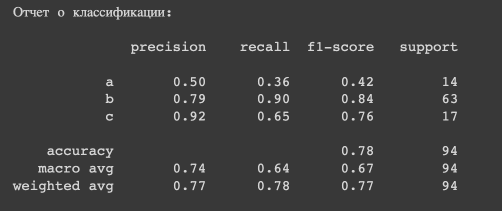
- далее подберем оптимальные гиперпараметры с помощью gridsearch, задавая параметры, в соответствии с таблицей в след ячейке.

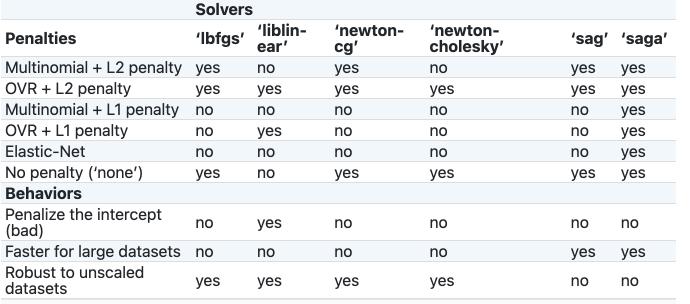

In [94]:
%%time
model = LogisticRegression(multi_class='multinomial',
                           max_iter = 5000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'''accuracy: {accuracy_score(y_test, y_pred)}''')

accuracy: 0.7978723404255319
CPU times: user 2min 58s, sys: 3min 32s, total: 6min 30s
Wall time: 4min 10s


In [95]:
classification_report_result = classification_report(y_test, y_pred)
print(f'''Отчет о классификации:

{classification_report_result}''')

Отчет о классификации:

              precision    recall  f1-score   support

           a       0.75      0.20      0.32        15
           b       0.78      0.95      0.86        61
           c       0.88      0.78      0.82        18

    accuracy                           0.80        94
   macro avg       0.80      0.64      0.67        94
weighted avg       0.80      0.80      0.77        94



Видим, что очень плохо предсказывает класс а, похоже на случайные.

Не получилось получить результат от gridserch. Сначала выберу лучший solver, а затем только для него найду лучшие гиперпараметры.

In [86]:
solvers = ['lbfgs','newton-cg','sag', 'saga']

In [89]:
# выполнялась 11 мин
for solver in solvers:
  model.solver = solver
  scores = cross_val_score(model,
                          X_train,
                          y_train,
                          cv = 5)
  print(f'''{solver} {mean(scores)}''')

lbfgs 0.8203703703703702
newton-cg 0.8203703703703702


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


sag 0.8420634920634921
saga 0.8420634920634921


Оставляем solver sag и saga.

In [66]:
# сетка для поиска параметров
param_grid = [
  {'solver':[ 'sag'], 'penalty':['l2'], 'C': [1, 10, 100, 1000]},
  {'solver':[ 'sag'], 'penalty': [None]},
  {'solver':[ 'saga'], 'penalty':['l2'], 'C': [1, 10, 100, 1000]},
  {'solver':[ 'saga'], 'penalty': [None]}
 ]

тюнингуем модель используя gridsearch для настройки гиперпараметров

Я убрала из gridsearch сетки варианты с 'solver':'lbfgs', так как при запуске выходило сообщение, что модель не может достичь сходимости и предлагаллось увеличить число итераций. А учитывая что у меня уже стоит 5000, я приняла решение оставить только другие solvers.

In [ ]:
%%time
# Выбираем лучшие гиперпараметры
grid_search = GridSearchCV(model,
                           param_grid = param_grid,
                           cv=5)
# обучаем
grid_search.fit(X_train, y_train)

In [87]:
# Получаем результаты работы модели
results = grid_search.cv_results_
pd.DataFrame.from_dict(results)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,75.017812,13.936342,9.189112,0.955662,1,l2,sag,"{'C': 1, 'penalty': 'l2', 'solver': 'sag'}",0.892857,0.857143,0.785714,0.785714,0.888889,0.842063,0.047645,1
1,71.306851,18.226508,8.227384,2.783553,10,l2,sag,"{'C': 10, 'penalty': 'l2', 'solver': 'sag'}",0.892857,0.857143,0.785714,0.785714,0.888889,0.842063,0.047645,1
2,72.408649,14.526148,7.471955,1.561067,100,l2,sag,"{'C': 100, 'penalty': 'l2', 'solver': 'sag'}",0.892857,0.857143,0.785714,0.785714,0.888889,0.842063,0.047645,1
3,68.987974,14.208802,9.196739,1.220332,1000,l2,sag,"{'C': 1000, 'penalty': 'l2', 'solver': 'sag'}",0.892857,0.857143,0.785714,0.785714,0.888889,0.842063,0.047645,1
4,68.609537,15.953637,9.352644,1.238650,NaN,None,sag,"{'penalty': None, 'solver': 'sag'}",0.892857,0.857143,0.785714,0.785714,0.888889,0.842063,0.047645,1
5,67.363876,6.163254,9.033444,1.514031,1,l2,saga,"{'C': 1, 'penalty': 'l2', 'solver': 'saga'}",0.892857,0.857143,0.785714,0.785714,0.888889,0.842063,0.047645,1
6,65.172696,6.198850,9.315545,1.567207,10,l2,saga,"{'C': 10, 'penalty': 'l2', 'solver': 'saga'}",0.892857,0.857143,0.785714,0.785714,0.888889,0.842063,0.047645,1
7,70.708117,4.976512,6.375128,2.003598,100,l2,saga,"{'C': 100, 'penalty': 'l2', 'solver': 'saga'}",0.892857,0.857143,0.785714,0.785714,0.888889,0.842063,0.047645,1
8,69.137885,4.995143,8.102069,2.113357,1000,l2,saga,"{'C': 1000, 'penalty': 'l2', 'solver': 'saga'}",0.892857,0.857143,0.785714,0.785714,0.888889,0.842063,0.047645,1
9,69.107788,5.671585,7.486261,1.582984,NaN,None,saga,"{'penalty': None, 'solver': 'saga'}",0.892857,0.857143,0.785714,0.785714,0.888889,0.842063,0.047645,1


In [88]:
# Выводим значения метрики F1 при лучших гиперпараметрах
best_score = grid_search.best_score_

print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", best_score)

Best hyperparameters:  {'C': 1, 'penalty': 'l2', 'solver': 'sag'}
Best score:  0.8420634920634921


Проверим работу модели на этих гиперпараметрах на кроссвалидации

In [71]:
model = LogisticRegression(multi_class='multinomial',
                           max_iter = 5000,
                           C = 1,
                           penalty= 'l2',
                           solver = 'sag')

CPU times: user 28 µs, sys: 2 µs, total: 30 µs
Wall time: 34.3 µs


In [72]:
# параметры для кросвалидации
cv = RepeatedStratifiedKFold(n_splits=10,
                             n_repeats=3,
                             random_state=21
                             )

In [73]:
%%time
scores = cross_val_score(model,
                         df[X],
                         df[y],
                         scoring='accuracy',
                         cv=cv,
                         n_jobs=-1,
                         verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


CPU times: user 5min 7s, sys: 11.8 s, total: 5min 19s
Wall time: 1h 20min 27s


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 80.4min finished


In [96]:
print('Accuracy: %.3f (%.3f)' , (mean(scores), std(scores)))

Accuracy: %.3f (%.3f) (0.8241545893719807, 0.05857164192458528)


In [100]:
%%time
model = LogisticRegression(multi_class='multinomial',
                           max_iter = 5000,
                           C = 1,
                           penalty= 'l2',
                           solver = 'sag')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
classification_report_result = classification_report(y_test, y_pred)

print(f'''Отчет о классификации итоговый:
{classification_report_result}''')

Отчет о классификации валидационный:
              precision    recall  f1-score   support

           a       0.60      0.20      0.30        15
           b       0.78      0.95      0.86        61
           c       0.93      0.78      0.85        18

    accuracy                           0.80        94
   macro avg       0.77      0.64      0.67        94
weighted avg       0.78      0.80      0.77        94

CPU times: user 1min 1s, sys: 75.8 ms, total: 1min 1s
Wall time: 1min 6s


# Вывод

**Описание полученных результатов**

В ходе работы я получала предсказания к какому уровню языка относится  фильм (целевой признак level), предполагалась одна из категорий:
- a
- b
- c.
Эти категории я получила объединив все подкатегории имеющиеся в датасете (а1,b2, a2/b1 и т.д.).
После объединения подуровне в основные уровни выборка сбалансирована следующим образом:

15/70/15 соответственно.

В результате выполнения проекта по предсказанию уровня языка в фильме
   
модель логистической регрессии без настройки гиперпараметров показала такие результаты:

    precision    recall  f1-score   


```
a   0.75      0.20     0.32        
b   0.78      0.95     0.86        
c   0.88      0.78     0.82

```
`accuracy     0.7978  `      
    
Но несмотря на то, что среднее accuracy достигает удовлетворительных результатов, эта модель предсказывает плохо редкие классы a и c.

Изначально я задала сетку для поиска гиперпараметров, со всеми solvers и подбором числа итераций, но это потребовало высоких вычислительных мощностей и за 7 часов выполнения ячейки я все еще не получила результат.

Дальше я ввела дополнительный шаг и циклом нашла лучший solver, и ввела число итераций равное 5000. и запустила gridsearchCV для поиска лучших гиперпараметров (solver (saga, sag),С, penalty).


C помощью метода gridsearchCV были найдены лучшие гиперпараметры:

```
Best hyperparameters:  
- 'C': 1,
- 'penalty': 'l2',
- 'solver': 'sag'
- max_iter = 5000

Best score:  0.8420634920634921
```

Далее я запустила модель на найденных гиперпараметрах используя метод repeatedCV(), исходя из того что у нас маленький датасет и получила метрику accuracy равную

```
accuracy: 0.8241545893719807
```

Таким образом, в результате подбора гиперпараметров нам удалось улучшить baseline метрику на 0.0442.
Ниже представлена динамика изменений остальных метрик после использования найденных гиперпараметров на тестовой выборке.
 `precision    recall  f1-score  `

```
a   + 0.15      0     + 0.2        
b     0         0     0        
c   - 0.45      0     + 0.03

```
`accuracy     0.7978  `  

Основная цель проекта достигнута:
- Мы получили метрику, которая достигает заданных изначально критериев - выше 60%.


**Этапы работы над проектом.**


Исходные данные содержали текст субтитров.
В данной работе мы обработали исходные тексты субтитров в два этапа:
 - стандартными библиотеками Pandas и Python.
 Создали функцию, которая:
 - привела все слова к нижнему регистру
 - убрала знак /n
 - убрала знаки препинания (кроме ',пробела и '.')

 Далее я создала функцию, включающую в себя этапы обработки текста библиотеки nltk:
 - tokenizer
 - lemmatizer
 - stop_words().

 После применения этой функции к предварительно оработанному столбцу я получила текст субтитров, включающий в себя слова в исходной форме (лемматизация), и очищенный от лишних слов (артикли, предлоги. Слова находящиеся в спец словаре stop_words).

 Далее я создала мешок слов из полученных этими способоми текстов и на основе их создала вектора признаков.

 Далее я обучила модель на основе этих признаков и получила предсказание.


 **Перспективы:**

 В данной работе была исследована только одна модель, logisticRegression(), что недостаточно и нужно рассмотреть другие модели и алгоритмы:
1. Многоклассовая наивная байесовская классификация
2. Метод опорных векторов (SVM)
3. Метод k-ближайших соседей (k-NN)
4. Случайный лес (Random Forest)
5. Градиентный бустинг (Gradient Boosting)
6. Нейронные сети
7. Использовать классификатор собранный через Pipeline.

Необходимо использовать другую метрику, так как accuracy не дает подробной информации о реальной работе модели, как уже говорилось выше, в высоких результатах accuracy не видно, что модель плохо предсказывает редкие классы, а у нас выборки несбалансирована.

Необходимо обогатить датасет, так как у нас имеется всего 233 объекта, что однозачно недостаточно.

Разбивать на подклассы уровней не вижу смысла, так как тогда классы станут еще более скудными и работа модели ухудшится.
Но можно использовать подбор treshhold чтобы отрегулировать пограничные предсказания.




bye bye!